# Neural networks with TensorFlow (from scratch)
Adapted from Chap. 10 of `Hands-on Machine Learning with Scikit-Learn and TensorFlow` by A. Geron

Let us start with a simple Perceptron, available directly in `scikit-learn` as `Perceptron` class. `Perceptron` is a "linear threshold unit", computing its output as
$$
\textrm{output} = \textrm{step}(\mathbf{w}^T \mathbf{x}).
$$
Here $\mathbf{w}$ is the weight vector and $\textrm{step}$ is the step function. Weights are updated with an SGD-like formula
$$
w_{i,j}^{new} = w_{i,j} + \eta (y_j - \hat{y}_j) x_i.
$$
For details, see the book.

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

iris = load_iris()

print('Shape of input data:', iris.data.shape)
print('Shape of targets:', iris.target.shape)
print('Target values:', set(iris.target))

X = iris.data[:, (2, 3)] # Only use petal length and width
y = (iris.target == 0).astype(np.int) # Binary classification to detect Iris Setosas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

per_clf = Perceptron(random_state=42)
per_clf.fit(X_train, y_train)

y_pred = per_clf.predict(X_test)

score = per_clf.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)

print('Prediction score:', score)
print('Accuracy:', accuracy)

Shape of input data: (150, 4)
Shape of targets: (150,)
Target values: {0, 1, 2}
Prediction score: 1.0
Accuracy: 1.0


/Users/ksaaskil/.pyenv/versions/3.5.0/envs/python3.5.0/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


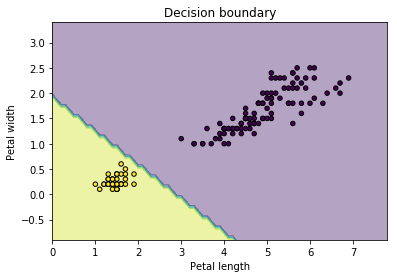

In [2]:
import matplotlib.pyplot as plt
# Plotting decision regions, see http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = per_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig = plt.figure()
ax = plt.gca()

ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
ax.set_title('Decision boundary')
ax.set_xlabel('Petal length')
ax.set_ylabel('Petal width')

plt.show()

Single-layer perceptrons are incapable of solving some trivial problems like learning `XOR`. This limitation can be overcome by stacking multiple perceptrons to form a _Multi-layer Perceptron_. Perceptron with two or more hidden layers is called an artificial neural network (ANN). ANNs are trained using the backpropagation algorithm ([article](https://scholar.google.com/scholar?q=Learning+Internal+Representations+by+Error+Propagation)). For each training instance, the backprop algorithm first makes a prediction (forward pass), measures the error, then goes through each layer in reverse to measure the error contribution from each connection (reverse pass), and finally updates the connection weights to reduce the error. The algorithm essentially measures the error gradient across all connection weights in the network by propagating the error gradient backward in the network. Since step function used as output in Perceptron has zero gradient almost everywhere, it needed to be replaced with a different _activation function_. Most common activation functions are hyperbolic tangent function, logistic function, and the rectified linear unit (ReLU). ReLUs and its variants generally perform best for ANNs and are therefore most commonly used.

ANNs are most straightforward to train using [Keras](https://keras.io/), a high-level Python API bundled with TensorFlow.

/Users/ksaaskil/.pyenv/versions/3.5.0/envs/python3.5.0/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


30/30 [==============================]30/30 [==============================] - 0s 682us/step

Test accuracy: 1.0


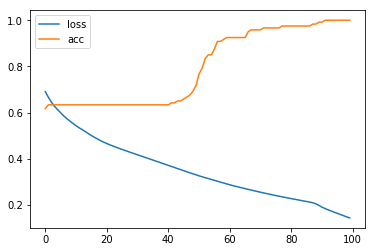

In [3]:
import tensorflow as tf

from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(20, input_shape=(2,), activation=tf.nn.relu), # Layer with 20 units and ReLU activation
    keras.layers.Dense(10, activation=tf.nn.relu), # Layer with 10 units and ReLU activation
    keras.layers.Dense(1, activation=keras.activations.sigmoid) # Sigmoid outputting values between 0 and 1
])

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy', # Computes cross-entropy between true labels and predictions from sigmoid
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, verbose=0)

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['acc'], label='acc')
plt.legend()

plt.show()

To better understand ANNs, let us go through building one without resorting to Keras, using the MNIST dataset.

In [4]:
import tensorflow as tf

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X") # Number of training samples in batch not known and not required
y = tf.placeholder(tf.int64, shape=(None), name="y") # y is a 1D array with unknown length

def neuron_layer(X, n_neurons, name, activation=lambda x: x):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1]) # Number of features
        stddev = 2 / np.sqrt(n_inputs + n_neurons) # Xavier initialization
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev) # Random initialization for weights
        W = tf.Variable(init, name="kernel") # Connection weights
        b = tf.Variable(tf.zeros([n_neurons]), name="bias") # Biases, can be initialized to zero
        Z = tf.matmul(X, W) + b # Size (n_batch, n_neurons), bias vector b added to each row (each sample)
        return activation(Z)


with tf.name_scope("ann"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs") # Unscaled as softmax computed later internally
    

with tf.name_scope("loss"):
    # This op expects unscaled logits, since it performs a softmax on logits internally for efficiency.
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

# Evaluate performance by checking if the correct label is in top 1:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/mnist/data")

n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy", acc_val)
    save_path = saver.save(sess, "./my_model.ckpt")

Extracting /tmp/mnist/data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/t10k-labels-idx1-ubyte.gz
0 Train accuracy: 0.92 Val accuracy 0.9128
1 Train accuracy: 0.88 Val accuracy 0.9298
2 Train accuracy: 0.96 Val accuracy 0.9378
3 Train accuracy: 0.96 Val accuracy 0.9432
4 Train accuracy: 0.94 Val accuracy 0.948
5 Train accuracy: 0.96 Val accuracy 0.9542
6 Train accuracy: 1.0 Val accuracy 0.9582
7 Train accuracy: 0.94 Val accuracy 0.9626
8 Train accuracy: 0.9 Val accuracy 0.9642
9 Train accuracy: 0.92 Val accuracy 0.9648
10 Train accuracy: 0.94 Val accuracy 0.9658
11 Train accuracy: 0.98 Val accuracy 0.9672
12 Train accuracy: 0.98 Val accuracy 0.9672
13 Train accuracy: 0.96 Val accuracy 0.9698
14 Train accuracy: 0.98 Val accuracy 0.9714
15 Train accuracy: 0.96 Val accuracy 0.973
16 Train accuracy: 1.0 Val accuracy 0.9732
17 Train accuracy: 1.0 Val accuracy 0.9738
18 Train a

The `neuron_layer` function could be replaced with built-in dense layers as follows:
```python

with tf.name_scope("ann"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
```

After training, predictions can be made by restoring the model and evaluating predictions:

In [5]:
X_val = mnist.validation.images
y_val = mnist.validation.labels

with tf.Session() as sess:
    saver.restore(sess, "./my_model.ckpt")
    Z = logits.eval(feed_dict={X: X_val})
    y_pred = np.argmax(Z, axis=1)

from sklearn.metrics import accuracy_score, precision_score, recall_score

print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred, average='macro'))
print('Recall:', recall_score(y_val, y_pred, average='macro'))

INFO:tensorflow:Restoring parameters from ./my_model.ckpt
Accuracy: 0.977
Precision: 0.9768671356749312
Recall: 0.9769312917282991
